## Import and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## Implement Denoising Autoencoder

In [2]:
class DenoisingAutoencoder(nn.Module):
    """
    Implementation of: "Extracting and Composing Robust Features with Denoising Autoencoders"
    Vincent et al., 2008

    Key features from the paper:
    - Stochastic corruption of input (masking noise)
    - Learn mapping from corrupted data to clean data
    - Single hidden layer architecture
    - Sigmoid activation functions
    """

    def __init__(self, input_dim=784, hidden_dim=500, corruption_level=0.3):
        """
        Args:
            input_dim: Dimension of input data (784 for MNIST)
            hidden_dim: Size of hidden layer (500 as in paper)
            corruption_level: Probability of corrupting each input element
        """
        super(DenoisingAutoencoder, self).__init__()
        self.corruption_level = corruption_level

        # Encoder (as described in paper)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()  # Using sigmoid as in original paper
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Output between 0-1 for pixel values
        )

    def corrupt_input(self, x):
        """
        Implements the masking noise corruption from the paper (Section 2.1)
        For each element, with probability corruption_level, set it to 0
        """
        if self.corruption_level == 0:
            return x

        # Create corruption mask - 1 means keep, 0 means corrupt
        corruption_mask = torch.rand_like(x) > self.corruption_level
        corrupted_x = x * corruption_mask.float()

        return corrupted_x

    def forward(self, x, apply_corruption=True):
        """
        Forward pass as described in paper:
        1. Corrupt the input
        2. Encode corrupted input to hidden representation
        3. Decode hidden representation to reconstruct original

        Args:
            x: Input tensor
            apply_corruption: Whether to apply corruption (False for evaluation)
        """
        # Flatten input if it's an image
        original_shape = x.shape
        x_flat = x.view(x.size(0), -1)

        # Step 1: Corrupt input (during training)
        if apply_corruption and self.training:
            corrupted_x = self.corrupt_input(x_flat)
        else:
            corrupted_x = x_flat

        # Step 2: Encode corrupted input
        hidden = self.encoder(corrupted_x)

        # Step 3: Decode to reconstruct ORIGINAL input
        reconstructed = self.decoder(hidden)
        reconstructed = reconstructed.view(original_shape)

        return reconstructed, hidden, corrupted_x.view(original_shape)

## Training function according to paper specifications

In [3]:
def train_denoising_ae(model, train_loader, test_loader, epochs=100, learning_rate=0.001):
    """
    Training procedure following the paper's approach:
    - Cross-entropy loss (for binary inputs like MNIST)
    - Standard gradient descent
    """

    # Using cross-entropy loss as mentioned in paper for binary data
    criterion = nn.BCELoss()  # Binary Cross-Entropy for MNIST pixels (0-1)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    test_losses = []

    model.to(device)

    print("Starting Denoising Autoencoder Training...")
    print("=" * 60)

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)

            optimizer.zero_grad()

            # Forward pass with corruption
            reconstructed, _, _ = model(data, apply_corruption=True)

            # Loss is between reconstruction and ORIGINAL data
            loss = criterion(reconstructed, data)

            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{epoch_train_loss/(batch_idx+1):.4f}'
            })

        avg_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase (no corruption during evaluation)
        avg_test_loss = evaluate_denoising_ae(model, test_loader, criterion)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    return train_losses, test_losses

def evaluate_denoising_ae(model, test_loader, criterion):
    """Evaluate the DAE on test data without corruption"""
    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)

            # No corruption during evaluation
            reconstructed, _, _ = model(data, apply_corruption=False)
            loss = criterion(reconstructed, data)

            test_loss += loss.item()

    return test_loss / len(test_loader)

## Visualization functions

In [4]:
def visualize_denoising_process(model, test_loader, num_examples=5):
    """
    Visualize the denoising process as shown in paper figures
    Shows: Original → Corrupted → Reconstructed
    """
    model.eval()

    # Get a batch of test data
    data, labels = next(iter(test_loader))
    data = data.to(device)

    with torch.no_grad():
        # Get reconstructions with corruption
        reconstructed, _, corrupted = model(data[:num_examples], apply_corruption=True)

    # Move to CPU for plotting
    data = data.cpu()
    reconstructed = reconstructed.cpu()
    corrupted = corrupted.cpu()

    # Create visualization
    fig, axes = plt.subplots(3, num_examples, figsize=(12, 6))

    for i in range(num_examples):
        # Original images (top row)
        axes[0, i].imshow(data[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original\nDigit {labels[i].item()}')
        axes[0, i].axis('off')

        # Corrupted images (middle row)
        axes[1, i].imshow(corrupted[i].squeeze(), cmap='gray')
        axes[1, i].set_title('Corrupted\nInput')
        axes[1, i].axis('off')

        # Reconstructed images (bottom row)
        axes[2, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[2, i].set_title('Reconstructed\nOutput')
        axes[2, i].axis('off')

    plt.suptitle('Denoising Autoencoder: Corruption and Reconstruction Process', fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_training_curves(train_losses, test_losses):
    """Plot training and test loss curves"""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', linewidth=2)
    plt.plot(test_losses, label='Test Loss', linewidth=2)
    plt.title('Denoising Autoencoder Training Progress', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-Entropy Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def compare_with_regular_ae(dae_loss, regular_ae_loss):
    """Compare DAE performance with regular autoencoder"""
    plt.figure(figsize=(10, 6))
    plt.plot(dae_loss, label='Denoising AE', linewidth=2)
    plt.plot(regular_ae_loss, label='Regular AE', linewidth=2)
    plt.title('DAE vs Regular Autoencoder Performance', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Data preparation

In [5]:
def prepare_data():
    """Prepare MNIST dataset with proper normalization"""
    transform = transforms.Compose([
        transforms.ToTensor(),  # Automatically scales to [0, 1]
    ])

    # Download and load MNIST
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return train_loader, test_loader

100%|██████████| 9.91M/9.91M [00:00<00:00, 62.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.64MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.5MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.56MB/s]


Training samples: 60000
Test samples: 10000
Denoising Autoencoder initialized:
  - Input dimension: 784
  - Hidden dimension: 500
  - Corruption level: 30%
  - Total parameters: 785,284
Starting Denoising Autoencoder Training...


Epoch 1/50: 100%|██████████| 469/469 [00:07<00:00, 59.69it/s, Loss=0.1256, Avg Loss=0.1873]


Epoch 1: Train Loss: 0.1873, Test Loss: 0.1278


Epoch 2/50: 100%|██████████| 469/469 [00:08<00:00, 57.17it/s, Loss=0.1078, Avg Loss=0.1195]


Epoch 2: Train Loss: 0.1195, Test Loss: 0.1076


Epoch 3/50: 100%|██████████| 469/469 [00:08<00:00, 56.05it/s, Loss=0.0996, Avg Loss=0.1056]


Epoch 3: Train Loss: 0.1056, Test Loss: 0.1001


Epoch 4/50: 100%|██████████| 469/469 [00:07<00:00, 60.95it/s, Loss=0.0973, Avg Loss=0.1000]


Epoch 4: Train Loss: 0.1000, Test Loss: 0.0966


Epoch 5/50: 100%|██████████| 469/469 [00:07<00:00, 60.90it/s, Loss=0.0950, Avg Loss=0.0970]


Epoch 5: Train Loss: 0.0970, Test Loss: 0.0935


Epoch 6/50: 100%|██████████| 469/469 [00:08<00:00, 55.92it/s, Loss=0.0944, Avg Loss=0.0948]


Epoch 6: Train Loss: 0.0948, Test Loss: 0.0924


Epoch 7/50: 100%|██████████| 469/469 [00:08<00:00, 55.22it/s, Loss=0.0928, Avg Loss=0.0932]


Epoch 7: Train Loss: 0.0932, Test Loss: 0.0912


Epoch 8/50: 100%|██████████| 469/469 [00:07<00:00, 64.50it/s, Loss=0.0907, Avg Loss=0.0918]


Epoch 8: Train Loss: 0.0918, Test Loss: 0.0909


Epoch 9/50: 100%|██████████| 469/469 [00:08<00:00, 53.57it/s, Loss=0.0909, Avg Loss=0.0906]


Epoch 9: Train Loss: 0.0906, Test Loss: 0.0886


Epoch 10/50: 100%|██████████| 469/469 [00:08<00:00, 56.29it/s, Loss=0.0904, Avg Loss=0.0895]


Epoch 10: Train Loss: 0.0895, Test Loss: 0.0880


Epoch 11/50: 100%|██████████| 469/469 [00:07<00:00, 63.17it/s, Loss=0.0839, Avg Loss=0.0884]


Epoch 11: Train Loss: 0.0884, Test Loss: 0.0882


Epoch 12/50: 100%|██████████| 469/469 [00:07<00:00, 60.79it/s, Loss=0.0894, Avg Loss=0.0875]


Epoch 12: Train Loss: 0.0875, Test Loss: 0.0864


Epoch 13/50: 100%|██████████| 469/469 [00:08<00:00, 55.89it/s, Loss=0.0870, Avg Loss=0.0867]


Epoch 13: Train Loss: 0.0867, Test Loss: 0.0856


Epoch 14/50: 100%|██████████| 469/469 [00:08<00:00, 58.08it/s, Loss=0.0836, Avg Loss=0.0860]


Epoch 14: Train Loss: 0.0860, Test Loss: 0.0842


Epoch 15/50: 100%|██████████| 469/469 [00:07<00:00, 63.48it/s, Loss=0.0870, Avg Loss=0.0853]


Epoch 15: Train Loss: 0.0853, Test Loss: 0.0844


Epoch 16/50: 100%|██████████| 469/469 [00:08<00:00, 56.01it/s, Loss=0.0819, Avg Loss=0.0846]


Epoch 16: Train Loss: 0.0846, Test Loss: 0.0849


Epoch 17/50: 100%|██████████| 469/469 [00:08<00:00, 56.33it/s, Loss=0.0875, Avg Loss=0.0840]


Epoch 17: Train Loss: 0.0840, Test Loss: 0.0833


Epoch 18/50: 100%|██████████| 469/469 [00:07<00:00, 63.76it/s, Loss=0.0818, Avg Loss=0.0835]


Epoch 18: Train Loss: 0.0835, Test Loss: 0.0835


Epoch 19/50: 100%|██████████| 469/469 [00:07<00:00, 58.73it/s, Loss=0.0835, Avg Loss=0.0830]


Epoch 19: Train Loss: 0.0830, Test Loss: 0.0824


Epoch 20/50: 100%|██████████| 469/469 [00:08<00:00, 56.30it/s, Loss=0.0804, Avg Loss=0.0826]


Epoch 20: Train Loss: 0.0826, Test Loss: 0.0825


Epoch 21/50: 100%|██████████| 469/469 [00:07<00:00, 59.96it/s, Loss=0.0809, Avg Loss=0.0823]


Epoch 21: Train Loss: 0.0823, Test Loss: 0.0819


Epoch 22/50: 100%|██████████| 469/469 [00:07<00:00, 63.65it/s, Loss=0.0847, Avg Loss=0.0819]


Epoch 22: Train Loss: 0.0819, Test Loss: 0.0811


Epoch 23/50: 100%|██████████| 469/469 [00:08<00:00, 55.56it/s, Loss=0.0785, Avg Loss=0.0816]


Epoch 23: Train Loss: 0.0816, Test Loss: 0.0825


Epoch 24/50: 100%|██████████| 469/469 [00:09<00:00, 49.17it/s, Loss=0.0805, Avg Loss=0.0813]


Epoch 24: Train Loss: 0.0813, Test Loss: 0.0810


Epoch 25/50: 100%|██████████| 469/469 [00:07<00:00, 63.44it/s, Loss=0.0818, Avg Loss=0.0810]


Epoch 25: Train Loss: 0.0810, Test Loss: 0.0814


Epoch 26/50: 100%|██████████| 469/469 [00:08<00:00, 55.82it/s, Loss=0.0822, Avg Loss=0.0808]


Epoch 26: Train Loss: 0.0808, Test Loss: 0.0808


Epoch 27/50: 100%|██████████| 469/469 [00:08<00:00, 56.19it/s, Loss=0.0787, Avg Loss=0.0806]


Epoch 27: Train Loss: 0.0806, Test Loss: 0.0817


Epoch 28/50: 100%|██████████| 469/469 [00:07<00:00, 60.88it/s, Loss=0.0831, Avg Loss=0.0804]


Epoch 28: Train Loss: 0.0804, Test Loss: 0.0805


Epoch 29/50: 100%|██████████| 469/469 [00:07<00:00, 60.80it/s, Loss=0.0831, Avg Loss=0.0803]


Epoch 29: Train Loss: 0.0803, Test Loss: 0.0816


Epoch 30/50: 100%|██████████| 469/469 [00:08<00:00, 55.42it/s, Loss=0.0802, Avg Loss=0.0800]


Epoch 30: Train Loss: 0.0800, Test Loss: 0.0809


Epoch 31/50: 100%|██████████| 469/469 [00:08<00:00, 56.03it/s, Loss=0.0803, Avg Loss=0.0799]


Epoch 31: Train Loss: 0.0799, Test Loss: 0.0808


Epoch 32/50: 100%|██████████| 469/469 [00:07<00:00, 62.16it/s, Loss=0.0792, Avg Loss=0.0798]


Epoch 32: Train Loss: 0.0798, Test Loss: 0.0803


Epoch 33/50: 100%|██████████| 469/469 [00:08<00:00, 54.48it/s, Loss=0.0814, Avg Loss=0.0797]


Epoch 33: Train Loss: 0.0797, Test Loss: 0.0804


Epoch 34/50: 100%|██████████| 469/469 [00:08<00:00, 55.74it/s, Loss=0.0802, Avg Loss=0.0795]


Epoch 34: Train Loss: 0.0795, Test Loss: 0.0803


Epoch 35/50: 100%|██████████| 469/469 [00:07<00:00, 60.47it/s, Loss=0.0798, Avg Loss=0.0794]


Epoch 35: Train Loss: 0.0794, Test Loss: 0.0798


Epoch 36/50: 100%|██████████| 469/469 [00:07<00:00, 61.22it/s, Loss=0.0776, Avg Loss=0.0793]


Epoch 36: Train Loss: 0.0793, Test Loss: 0.0799


Epoch 37/50: 100%|██████████| 469/469 [00:08<00:00, 55.66it/s, Loss=0.0802, Avg Loss=0.0793]


Epoch 37: Train Loss: 0.0793, Test Loss: 0.0806


Epoch 38/50: 100%|██████████| 469/469 [00:08<00:00, 55.36it/s, Loss=0.0798, Avg Loss=0.0791]


Epoch 38: Train Loss: 0.0791, Test Loss: 0.0799


Epoch 39/50: 100%|██████████| 469/469 [00:07<00:00, 62.55it/s, Loss=0.0814, Avg Loss=0.0790]


Epoch 39: Train Loss: 0.0790, Test Loss: 0.0796


Epoch 40/50: 100%|██████████| 469/469 [00:08<00:00, 56.09it/s, Loss=0.0787, Avg Loss=0.0790]


Epoch 40: Train Loss: 0.0790, Test Loss: 0.0793


Epoch 41/50: 100%|██████████| 469/469 [00:08<00:00, 55.68it/s, Loss=0.0800, Avg Loss=0.0789]


Epoch 41: Train Loss: 0.0789, Test Loss: 0.0791


Epoch 42/50: 100%|██████████| 469/469 [00:07<00:00, 60.61it/s, Loss=0.0797, Avg Loss=0.0788]


Epoch 42: Train Loss: 0.0788, Test Loss: 0.0804


Epoch 43/50: 100%|██████████| 469/469 [00:07<00:00, 62.02it/s, Loss=0.0799, Avg Loss=0.0787]


Epoch 43: Train Loss: 0.0787, Test Loss: 0.0794


Epoch 44/50: 100%|██████████| 469/469 [00:08<00:00, 56.03it/s, Loss=0.0770, Avg Loss=0.0787]


Epoch 44: Train Loss: 0.0787, Test Loss: 0.0786


Epoch 45/50: 100%|██████████| 469/469 [00:08<00:00, 55.18it/s, Loss=0.0788, Avg Loss=0.0786]


Epoch 45: Train Loss: 0.0786, Test Loss: 0.0793


Epoch 46/50: 100%|██████████| 469/469 [00:07<00:00, 61.58it/s, Loss=0.0787, Avg Loss=0.0785]


Epoch 46: Train Loss: 0.0785, Test Loss: 0.0795


Epoch 47/50: 100%|██████████| 469/469 [00:08<00:00, 56.14it/s, Loss=0.0774, Avg Loss=0.0785]


Epoch 47: Train Loss: 0.0785, Test Loss: 0.0796


Epoch 48/50: 100%|██████████| 469/469 [00:08<00:00, 55.79it/s, Loss=0.0796, Avg Loss=0.0784]


Epoch 48: Train Loss: 0.0784, Test Loss: 0.0782


Epoch 49/50: 100%|██████████| 469/469 [00:07<00:00, 60.53it/s, Loss=0.0745, Avg Loss=0.0784]


Epoch 49: Train Loss: 0.0784, Test Loss: 0.0798


Epoch 50/50: 100%|██████████| 469/469 [00:07<00:00, 61.84it/s, Loss=0.0757, Avg Loss=0.0783]


Epoch 50: Train Loss: 0.0783, Test Loss: 0.0786


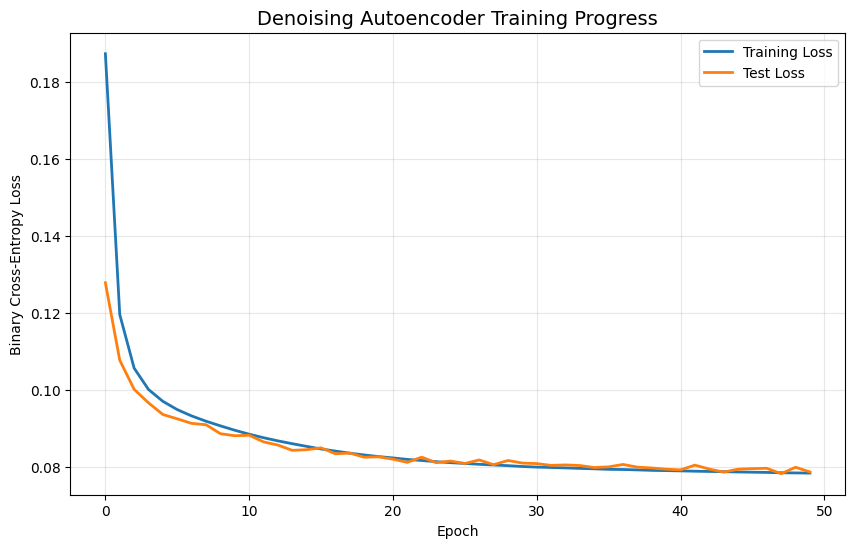

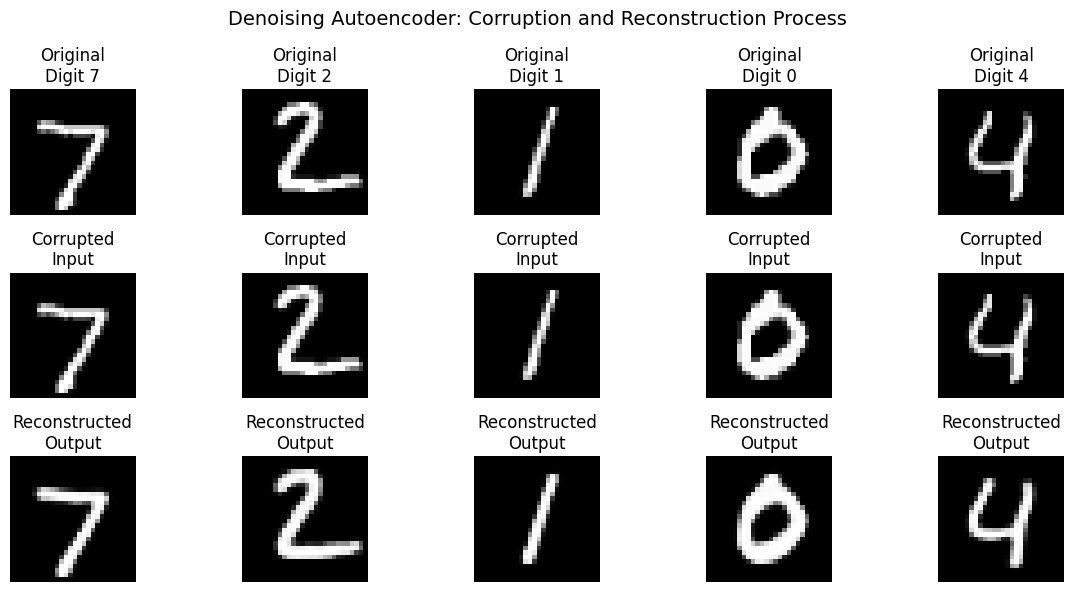


Testing different corruption levels:
Corruption 0%: Loss = 0.0786
Corruption 10%: Loss = 0.0786
Corruption 30%: Loss = 0.0786
Corruption 50%: Loss = 0.0786
Corruption 70%: Loss = 0.0786


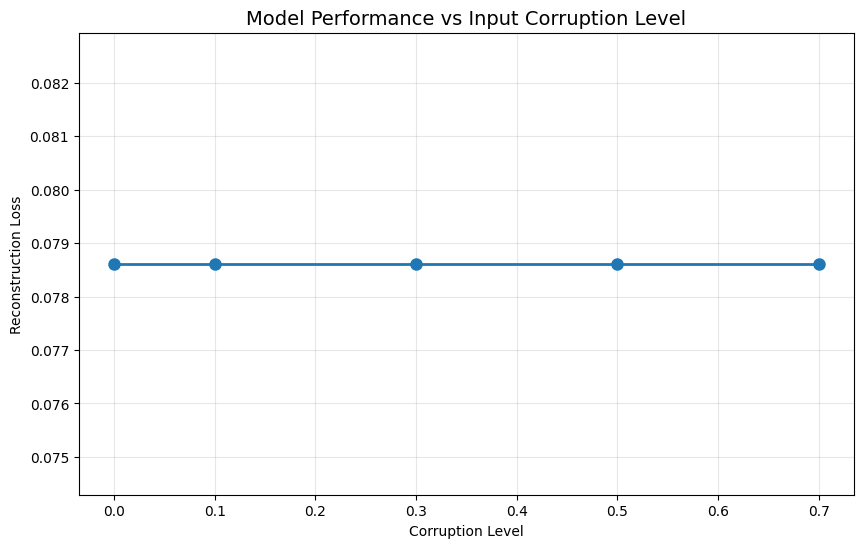

In [6]:
def main():
    """Main function to run the denoising autoencoder experiment"""

    # Prepare data
    train_loader, test_loader = prepare_data()

    # Initialize Denoising Autoencoder with paper parameters
    dae = DenoisingAutoencoder(
        input_dim=784,
        hidden_dim=500,  # As used in the paper
        corruption_level=0.3  # 30% corruption as mentioned
    )

    print(f"Denoising Autoencoder initialized:")
    print(f"  - Input dimension: 784")
    print(f"  - Hidden dimension: 500")
    print(f"  - Corruption level: 30%")
    print(f"  - Total parameters: {sum(p.numel() for p in dae.parameters()):,}")

    # Train the model
    train_losses, test_losses = train_denoising_ae(
        dae, train_loader, test_loader,
        epochs=50,  # Reduced for demonstration
        learning_rate=0.001
    )

    # Plot results
    plot_training_curves(train_losses, test_losses)

    # Visualize denoising process
    visualize_denoising_process(dae, test_loader, num_examples=5)

    # Test different corruption levels
    test_corruption_levels(dae, test_loader)

def test_corruption_levels(model, test_loader):
    """Test how the model handles different corruption levels"""
    model.eval()
    criterion = nn.BCELoss()

    corruption_levels = [0.0, 0.1, 0.3, 0.5, 0.7]
    losses = []

    print("\nTesting different corruption levels:")
    print("=" * 40)

    with torch.no_grad():
        for corruption_level in corruption_levels:
            # Temporarily change corruption level
            original_corruption = model.corruption_level
            model.corruption_level = corruption_level

            test_loss = 0
            for data, _ in test_loader:
                data = data.to(device)
                reconstructed, _, _ = model(data, apply_corruption=True)
                loss = criterion(reconstructed, data)
                test_loss += loss.item()

            avg_loss = test_loss / len(test_loader)
            losses.append(avg_loss)

            print(f"Corruption {corruption_level*100:.0f}%: Loss = {avg_loss:.4f}")

            # Restore original corruption level
            model.corruption_level = original_corruption

    # Plot corruption level vs performance
    plt.figure(figsize=(10, 6))
    plt.plot(corruption_levels, losses, 'o-', linewidth=2, markersize=8)
    plt.title('Model Performance vs Input Corruption Level', fontsize=14)
    plt.xlabel('Corruption Level')
    plt.ylabel('Reconstruction Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()